In [3]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [5]:
df = pd.read_csv('flight-price-prediction/clean_data_v2.csv')
df

,Airline,Source,Departure Time,Stops,Arrival Time,Destination,Class,Duration,Days Left,Price
0,SpiceJet,Delhi,Evening,0,Night,Mumbai,Economy,130,1,5953
1,SpiceJet,Delhi,Early_Morning,0,Morning,Mumbai,Economy,140,1,5953
2,AirAsia,Delhi,Early_Morning,0,Early_Morning,Mumbai,Economy,130,1,5956
3,Vistara,Delhi,Morning,0,Afternoon,Mumbai,Economy,135,1,5955
4,Vistara,Delhi,Morning,0,Morning,Mumbai,Economy,140,1,5955
...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,Chennai,Morning,1,Evening,Hyderabad,Business,605,49,69265
300149,Vistara,Chennai,Afternoon,1,Night,Hyderabad,Business,625,49,77105
300150,Vistara,Chennai,Early_Morning,1,Night,Hyderabad,Business,830,49,79099
300151,Vistara,Chennai,Early_Morning,1,Evening,Hyderabad,Business,600,49,81585


In [6]:
# We separate Target (Price) and Features
X = df.drop('Price', axis=1) # Input variables (includes all columns but price)
y = df['Price'] # Target variable (Price column)

In [7]:
# Identify the indices of categorical columns
# These are the columns CatBoost needs to treat specially
categorical_features_indices = np.where(X.dtypes == object)[0]

In [8]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Initialize CatBoost
# iterations: Number of trees to build (start with 1000)
# learning_rate: Step size (0.1 is a good starting point)
# depth: Height of the tree (6-10 is standard)
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=100  # Print progress every 100 iterations
)

In [10]:
# Train the Model
# giving it the list of categorical feature indices is the Magic Step
model.fit(
    X_train, 
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
    plot=True # Plots the training curve
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 20603.9255681	test: 20610.7391179	best: 20610.7391179 (0)	total: 288ms	remaining: 4m 47s
100:	learn: 4467.3871736	test: 4501.0151974	best: 4501.0151974 (100)	total: 11s	remaining: 1m 37s
200:	learn: 4188.3852979	test: 4227.6685277	best: 4227.6685277 (200)	total: 22.7s	remaining: 1m 30s
300:	learn: 4014.8589198	test: 4063.2742548	best: 4063.2742548 (300)	total: 34.4s	remaining: 1m 19s
400:	learn: 3886.9158239	test: 3945.4185222	best: 3945.4185222 (400)	total: 45.9s	remaining: 1m 8s
500:	learn: 3806.0551862	test: 3868.3513286	best: 3868.3513286 (500)	total: 58.1s	remaining: 57.9s
600:	learn: 3721.2079211	test: 3787.0813397	best: 3787.0813397 (600)	total: 1m 10s	remaining: 46.5s
700:	learn: 3651.6388988	test: 3722.7978545	best: 3722.7978545 (700)	total: 1m 21s	remaining: 35s
800:	learn: 3591.5038202	test: 3664.6875349	best: 3664.6875349 (800)	total: 1m 33s	remaining: 23.2s
900:	learn: 3545.8380840	test: 3622.4862990	best: 3622.4862990 (900)	total: 1m 45s	remaining: 11.5s
999:	le

In [11]:
# Evaluate
y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")

MAE: 2032.6196372550353
R2 Score: 0.9751076662462831


          Feature  Importance
6           Class   87.800063
7        Duration    3.438646
0         Airline    1.958076
1          Source    1.600424
5     Destination    1.552036
3           Stops    1.336332
8       Days Left    1.230726
4    Arrival Time    0.602147
2  Departure Time    0.481551


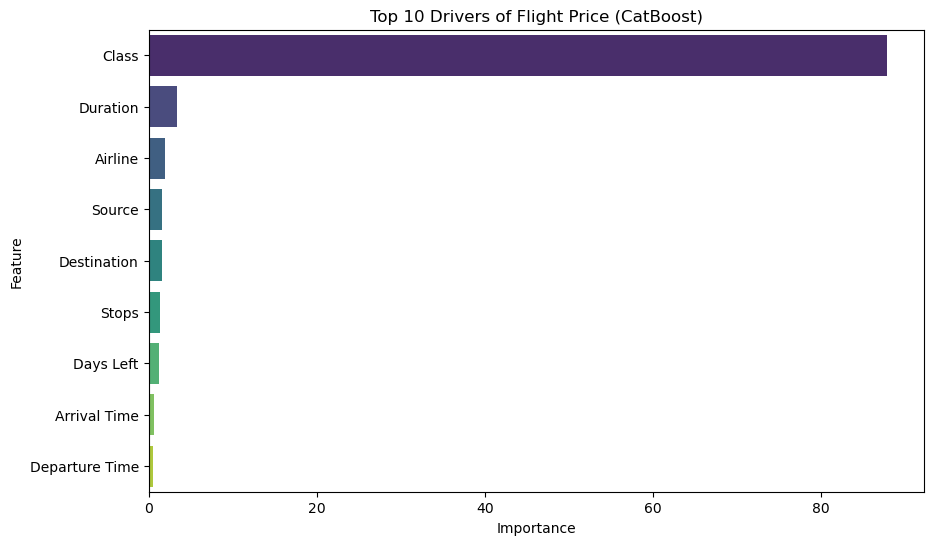

In [12]:
# Get the importance scores
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# Create a DataFrame to view them nicely
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# Display the drivers
print(fi_df.head(10))

# Visualizing for your presentation
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=fi_df.head(10), 
    hue='Feature',
    palette='viridis',
    legend=False
)
plt.title('Top 10 Drivers of Flight Price (CatBoost)')
plt.show()